### Import Libraries


In [1]:
import sys
import pathlib
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load

sys.path.append("../utils")
from split_utils import get_features_data


### Load Labeled Data


In [2]:
# load labeled data
labeled_data_path = pathlib.Path("../0.download_data/data/labeled_data.csv.gz")
labeled_data = get_features_data(labeled_data_path)
labeled_data

,Mitocheck_Phenotypic_Class,Cell_UUID,Location_Center_X,Location_Center_Y,Metadata_Plate,Metadata_Well,Metadata_Frame,Metadata_Site,Metadata_Plate_Map_Name,Metadata_DNA,...,DP__efficientnet_1270,DP__efficientnet_1271,DP__efficientnet_1272,DP__efficientnet_1273,DP__efficientnet_1274,DP__efficientnet_1275,DP__efficientnet_1276,DP__efficientnet_1277,DP__efficientnet_1278,DP__efficientnet_1279
0,Large,21da27ab-873a-41f4-ab98-49170cae9a2d,397,618,LT0010_27,173,83,1,LT0010_27_173,LT0010_27/LT0010_27_173_83.tif,...,1.526493,-0.388909,-0.715202,-0.939279,-0.077689,1.965509,18.685819,0.061676,2.641369,-0.086854
1,Large,82f7949b-4ea2-45c8-8dd9-7854caf49077,359,584,LT0010_27,173,83,1,LT0010_27_173,LT0010_27/LT0010_27_173_83.tif,...,-0.482883,-1.354858,-0.856680,-0.934949,0.725091,2.255450,-0.565433,1.628086,-0.605625,-0.748135
2,Large,cec7234f-fe35-4411-aded-f8112bb31219,383,685,LT0010_27,173,83,1,LT0010_27_173,LT0010_27/LT0010_27_173_83.tif,...,0.888706,1.350431,-0.648841,0.264205,0.131341,0.678315,0.171044,0.342206,-0.581597,0.505556
3,Large,43d9e7c9-c9ec-45ce-8820-048bfb896989,932,532,LT0013_38,42,75,1,LT0013_38_42,LT0013_38/LT0013_38_42_75.tif,...,-1.001625,-0.801021,-0.586539,0.076197,0.599191,1.742090,0.365520,0.643759,-1.906097,1.019370
4,Large,63ce6652-338e-4afd-9c77-dbc0e903bf92,477,130,LT0013_38,42,75,1,LT0013_38_42,LT0013_38/LT0013_38_42_75.tif,...,0.950706,-0.811825,-0.522427,-1.402842,-0.289940,2.661250,0.126978,-0.824945,-0.494285,1.763332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2911,OutOfFocus,380728fc-28b0-423f-b8a7-07be1af590d9,383,219,LT0601_01,217,49,1,LT0601_01_217,LT0601_01/LT0601_01_217_49.tif,...,0.549654,8.142944,1.619399,-1.521878,-0.182734,-1.608294,-0.783477,-2.613400,0.442609,1.977761
2912,OutOfFocus,30ed67c7-8de2-4d78-bce9-3fa1aff28565,975,294,LT0603_03,2,49,1,LT0603_03_2,LT0603_03/LT0603_03_2_49.tif,...,0.358861,6.294227,1.827482,-0.997080,-0.614779,-1.270435,-1.335869,-0.560155,0.836314,3.473351
2913,OutOfFocus,2960b13e-6090-4592-b2a9-d1c4c1b24b50,898,302,LT0603_03,2,49,1,LT0603_03_2,LT0603_03/LT0603_03_2_49.tif,...,0.570003,10.106912,1.130243,-1.288302,-0.956321,-1.409762,-0.058448,-0.025529,0.628679,1.657651
2914,OutOfFocus,fbc9ce6a-2b29-4115-b218-4ee5b8c50ac1,946,281,LT0603_03,2,49,1,LT0603_03_2,LT0603_03/LT0603_03_2_49.tif,...,-0.023441,11.088221,2.068912,-0.977407,-1.108647,-1.399433,-2.744383,-2.037700,0.667556,2.438798


### Creat esingle class model interpretations


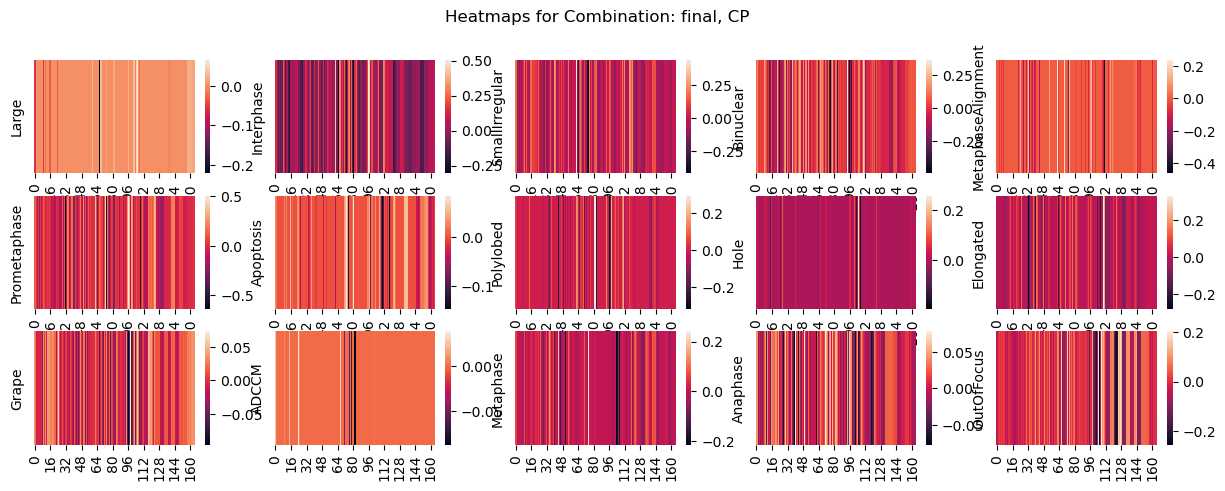

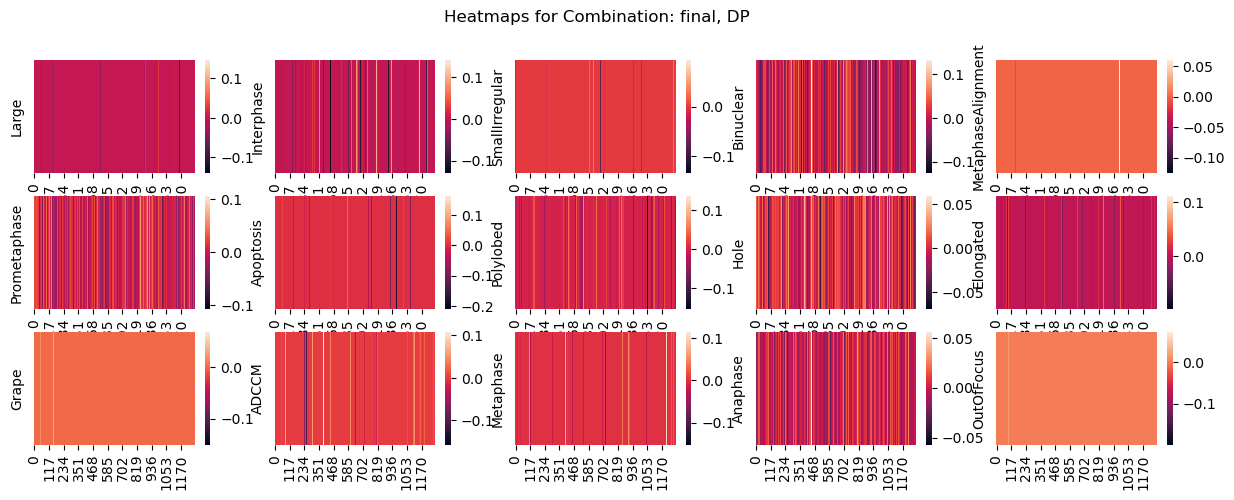

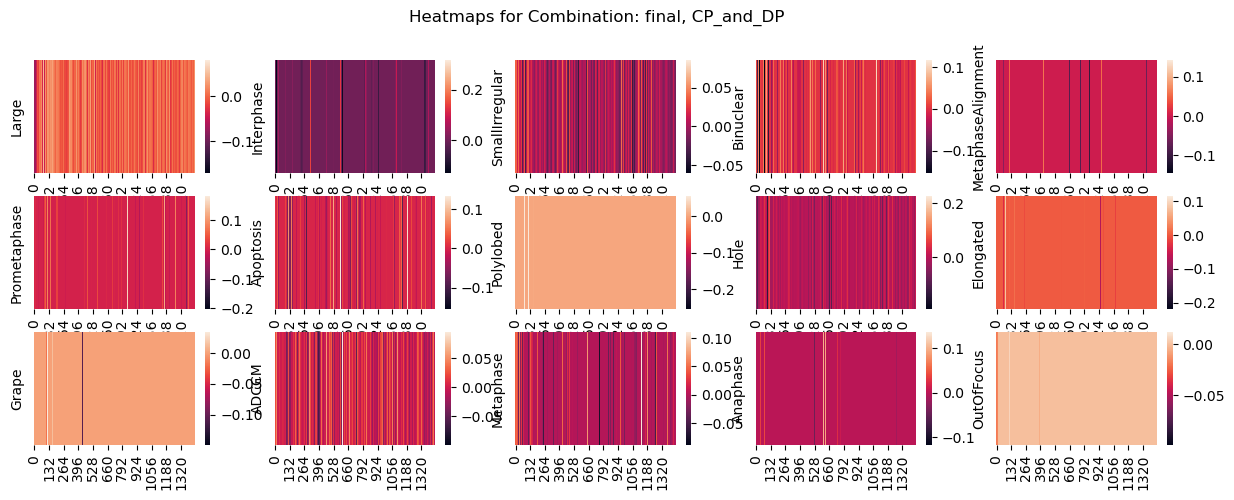

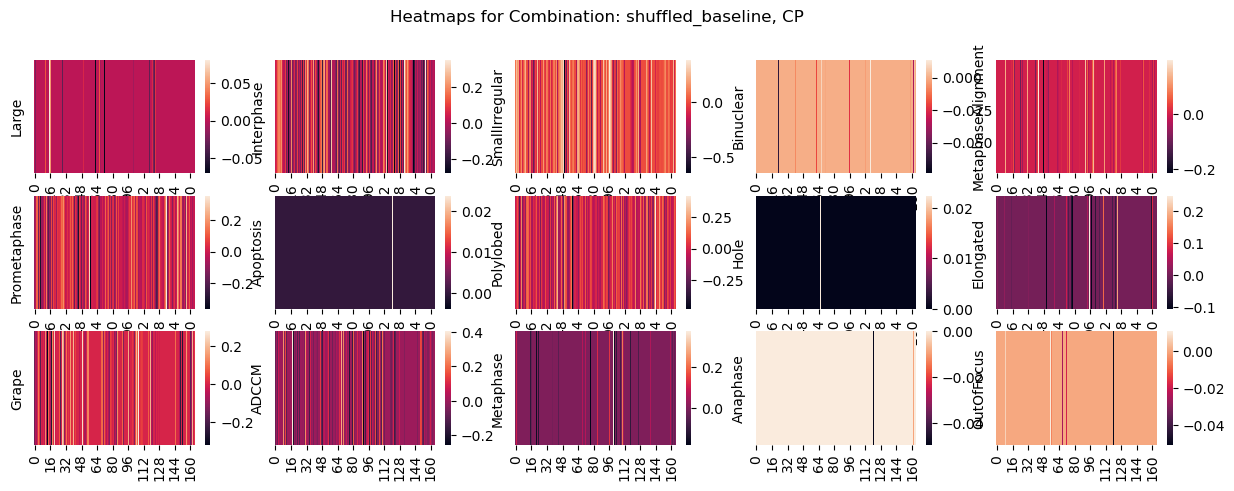

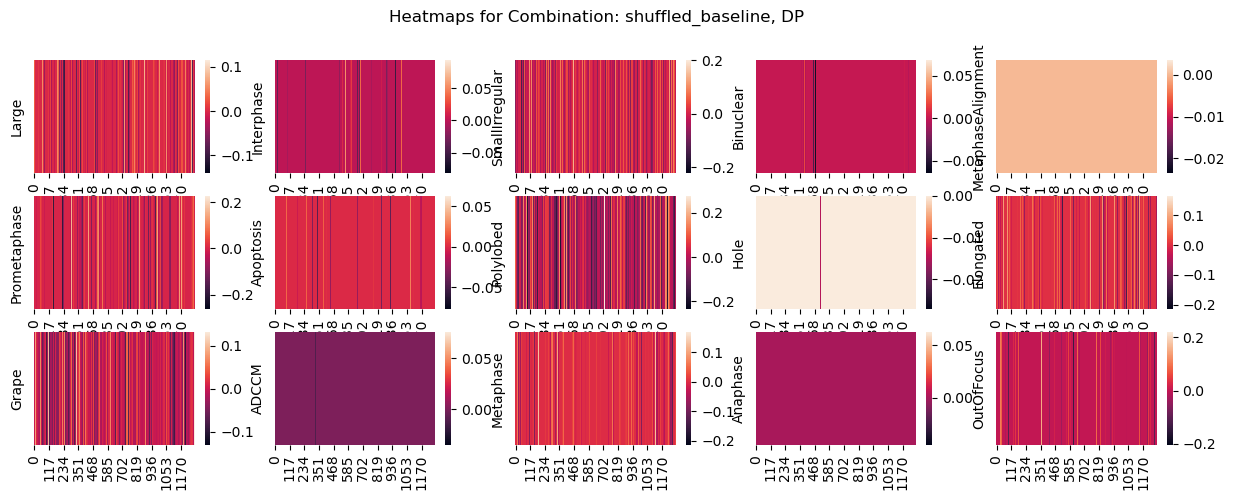

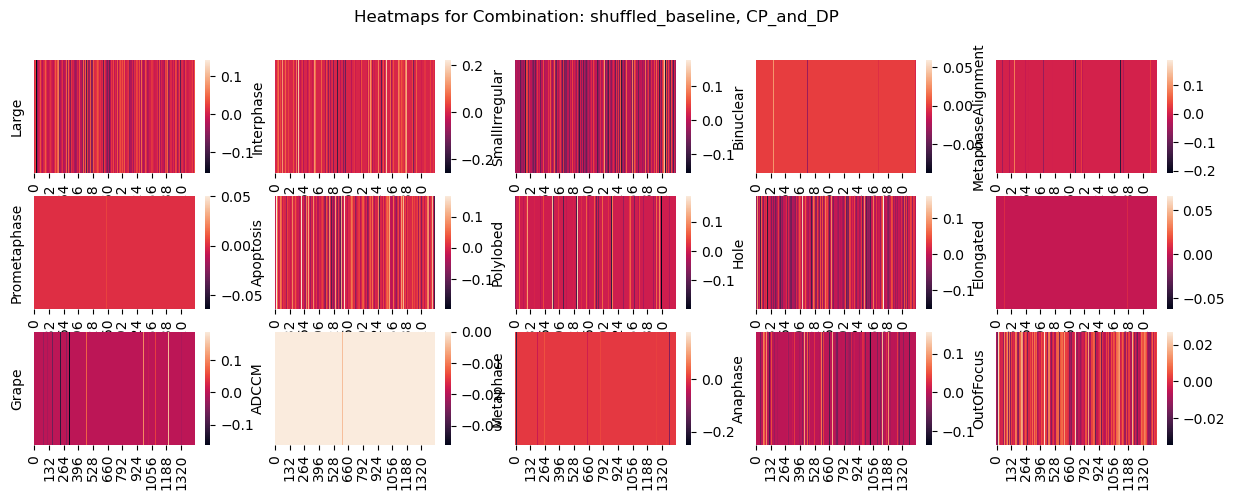

In [3]:
# directory to load the models from
models_dir = pathlib.Path("../2.train_model/models/single_class_models/")

# use a list to keep track of scores in tidy long format for each model and dataset combination
compiled_coefficients = []

# define combinations to test over
model_types = ["final", "shuffled_baseline"]
feature_types = ["CP", "DP", "CP_and_DP"]
phenotypic_classes = labeled_data["Mitocheck_Phenotypic_Class"].unique()

# iterate through each combination of feature_types, evaluation_types, phenotypic_classes
for model_type, feature_type in itertools.product(
    model_types, feature_types
):
    # create figures with 3x5 subplots for 15 phenotypic classes
    # heatmap figure/axs
    fig_hm, axs_hm = plt.subplots(3, 5)
    fig_hm.set_size_inches(15, 5)

    # variables to keep track of figure subplot coordinates
    ax_x = 0
    ax_y = 0

    for phenotypic_class in phenotypic_classes:
        # load single class model for this combination of model type, feature type, and phenotypic class
        single_class_model_path = pathlib.Path(
            f"{models_dir}/{phenotypic_class}_models/{model_type}__{feature_type}.joblib"
        )
        model = load(single_class_model_path)

        # get model coefficients and reshape them into a more useable format
        coefs = model.coef_
        coefs = pd.DataFrame(coefs).T

        # create tidy dataframe to keep track of coefficients in tidy long format
        tidy_data = coefs.copy(deep=True)
        tidy_data.columns = ["Coefficent_Value"]
        tidy_data["Phenotypic_Class"] = phenotypic_class
        tidy_data["shuffled"] = "shuffled" in model_type
        tidy_data["feature_type"] = feature_type

        # add feature names to coefficients dataframe
        # feature names depends on feature type
        all_cols = labeled_data.columns.tolist()
        # get DP,CP, or both features from all columns depending on desired dataset
        feature_cols = []
        if feature_type == "CP":
            feature_cols = [col for col in all_cols if "CP__" in col]
        elif feature_type == "DP":
            feature_cols = [col for col in all_cols if "DP__" in col]
        elif feature_type == "CP_and_DP":
            feature_cols = [col for col in all_cols if "P__" in col]
        tidy_data["Feature_Name"] = feature_cols

        # add tidy data to the compilation list
        compiled_coefficients.append(tidy_data)

        # add heatmap to figure
        sns.heatmap(data=coefs.T, ax=axs_hm[ax_x, ax_y])
        axs_hm[ax_x, ax_y].set_yticks([])
        axs_hm[ax_x, ax_y].set_ylabel(phenotypic_class)

        # increase row coordinate counter (this marks which subplot to plot on in vertical direction)
        ax_x += 1
        # if row coordinate counter is at maximum (3 rows of subplots)
        if ax_x == 3:
            # set row coordinate counter to 0
            ax_x = 0
            # increase column coordinate counter (this marks which subplot to plot on in horizontal direction)
            ax_y += 1

    # add title and axes labels to figure
    fig_hm.suptitle(
        f"Heatmaps for Combination: {model_type}, {feature_type}"
    )
    plt.plot()

### Save single class model coefficients

In [4]:
# compile list of tidy data into one dataframe
compiled_coefficients = pd.concat(compiled_coefficients).reset_index(drop=True)

# specify results directory
coefficients_dir = pathlib.Path("coefficients/")
coefficients_dir.mkdir(parents=True, exist_ok=True)

# define save path
compiled_coefficients_save_path = pathlib.Path(f"{coefficients_dir}/compiled_SCM_coefficients.tsv")

# save data as tsv
compiled_coefficients.to_csv(compiled_coefficients_save_path, sep="\t")

# preview tidy data
compiled_coefficients

,Coefficent_Value,Phenotypic_Class,shuffled,feature_type,Feature_Name
0,-0.053627,Large,False,CP,CP__AreaShape_Area
1,-0.060294,Large,False,CP,CP__AreaShape_BoundingBoxArea
2,0.000000,Large,False,CP,CP__AreaShape_BoundingBoxMaximum_X
3,0.000000,Large,False,CP,CP__AreaShape_BoundingBoxMaximum_Y
4,0.000000,Large,False,CP,CP__AreaShape_BoundingBoxMinimum_X
...,...,...,...,...,...
86695,0.002515,OutOfFocus,True,CP_and_DP,DP__efficientnet_1275
86696,-0.000478,OutOfFocus,True,CP_and_DP,DP__efficientnet_1276
86697,0.002833,OutOfFocus,True,CP_and_DP,DP__efficientnet_1277
86698,-0.005048,OutOfFocus,True,CP_and_DP,DP__efficientnet_1278
